# Förderhinweis

Dieses Dokument ist Teil des Lehrmaterials für die Fortbildung zum/zur **Berufsspezialist/in KI und Maschinelles Lernen.**

Die Entwicklung und Erprobung dieses Bildungsangebotes wurde vom Bundesministerium für Bildung und Forschung im Rahmen des InnoVET-Programms gefördert.

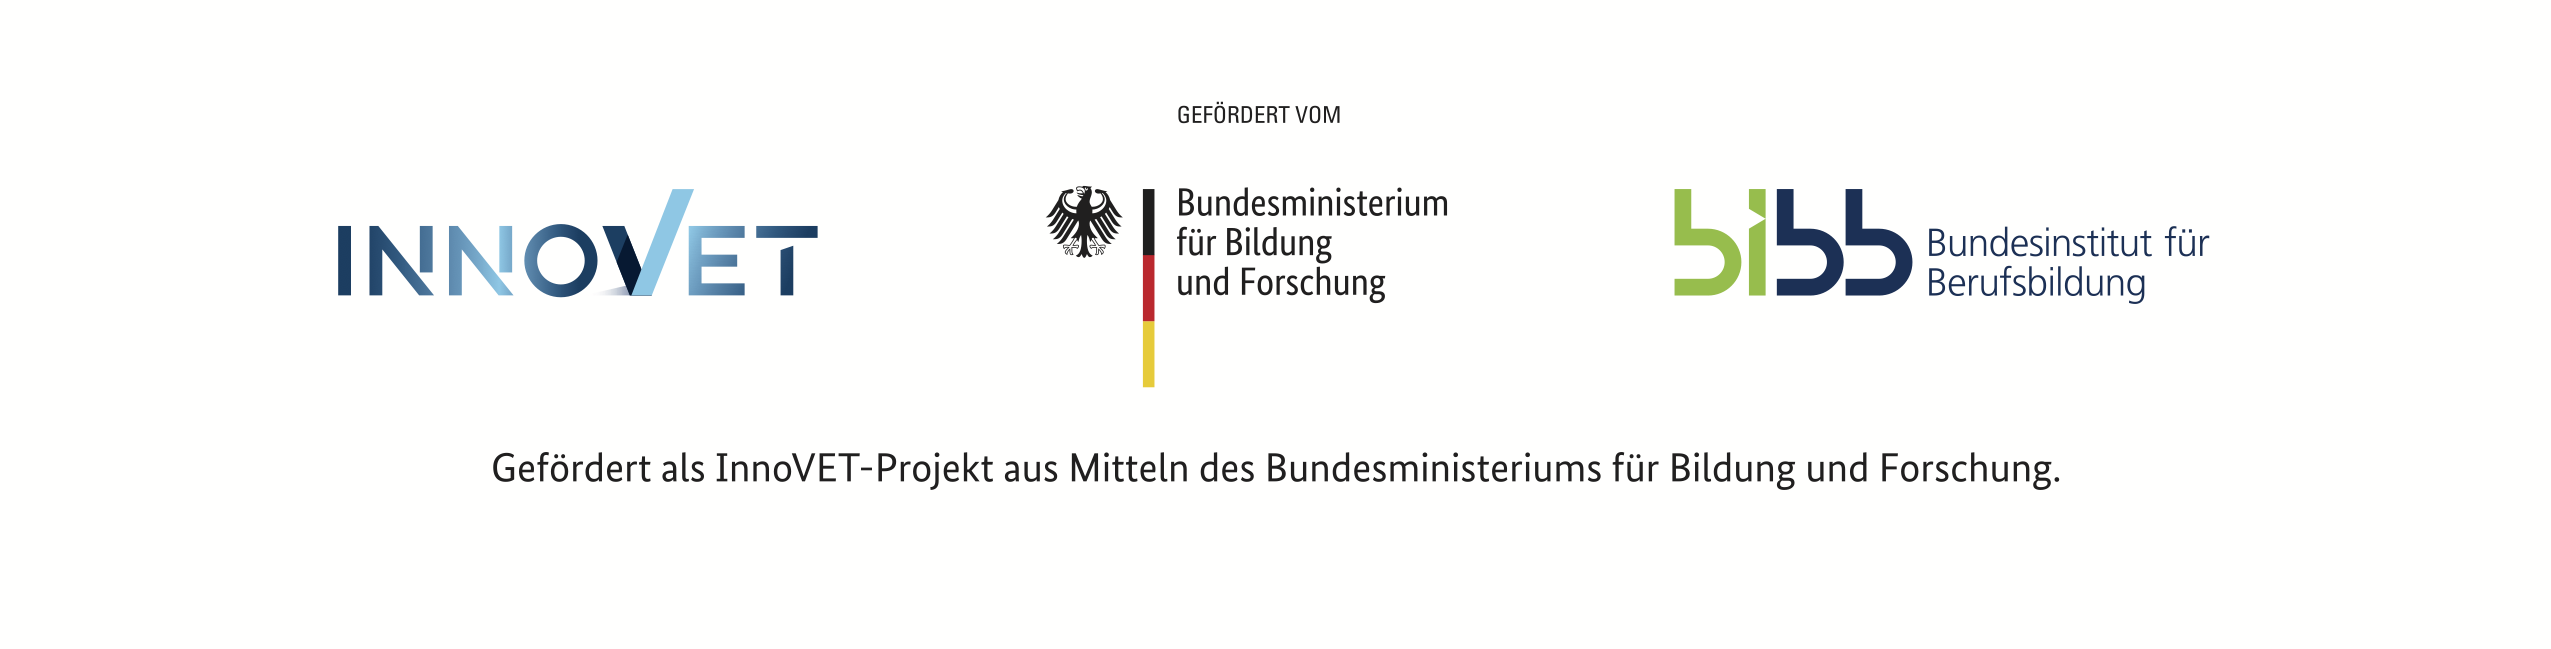

# Lizenzhinweis

Dieses Notebook "Erklärbarkeit am Beispiel CNNs" wurde von Antje Schweitzer, KI B3 / Universität Stuttgart, erstellt.

Das Werk, mit Ausnahme der oben abgebildeten Förderlogos, ist lizenziert unter [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/deed.de) (Namensnennung 4.0 International)

# Ziel dieses Projekts

Ziel des Projekts ist es, am Beispiel eines Netzwerks zur Bilderkennung die bei der Klassifikation entstehenden Daten innerhalb des Netzwerks zu visualisieren.

So kann man z.B. anhand der Feature Maps nachvollziehen, auf welche Regionen im Bild das Neuronale Netz reagiert, oder anders gesagt, welche Regionen im Bild starke Aktivierung bewirken und somit besonders zur Klassifikation des Objekts beitragen.

Bei Konvolutionskernen kann man außerdem in gewissem Maß visualisieren, auf welche Strukturen sie reagieren sollten.


# Themen in diesem Notebook

* Anwendung von ResNet zur Bilderkennung
* Struktur von ResNet
* Zugriff auf Eigenschaften von Konvolutionsschichten
* Visualisierung von Filterkernen
* Visualisierung von Feature Maps
* Visualisierung und Analyse der Aktivierung zur Verdeutlichung der Reaktion der Filterkerne auf Strukturen in konkreten Inputs

# ResNet-Modell laden

Wir laden das bereits trainierte ResNet-Modell, um es zur Objekterkennung verwenden zu können. Falls Sie das Projekt zu Transfer Learning bereits bearbeitet haben, kennen Sie dieses Modell vielleicht schon.

In [ ]:
import tensorflow as tf
import numpy as np

In [ ]:
resnet_model = tf.keras.applications.ResNet50V2(
    include_top=True,
    weights="imagenet",
    classes=1000,
    classifier_activation="softmax",
)

## Die Struktur von ResNet

Wir sehen uns dieses Modell erst einmal genauer an, zunächst die Arten von Schichten, die im Modell vorkommen. Diese kann man der Zusammenfassung (`summary()`) entnehmen. Wir haben also eine ganze Reihe bekannter Schichten: Konvolutionsschichten, MaxPooling-Schichten und Schichten zur Batchnormalisierung. Diese wurden in den Videos C7-7, C7-8 sowie C9-1 bis C9-5 besprochen. Ungewohnt ist hier allerdings, dass die Aktivierung als eigene Schicht implementiert ist. Man könnte die Aktivierung alternativ auch in der vorangehenden Schicht als Parameter angeben. Allerdings wurde beim Training von ResNet V2 genau damit experimentiert, an welcher Stelle die Aktivierung am besten verwendet werden sollte, und die unterschiedlichen Positionen der Aktivierung sind transparenter, wenn man sie als eigene Schicht implementiert. Außer den oben genannten Schichten gibt es ZeroPadding-Schichten. Diese dienen dazu, keine Daten am Rand des Inputs zu verlieren: da die Konvolutionskerne normalerweise nicht über den Rand des Inputs hinausgeschoben werden, verliert man bei jeder Konvolutionsschicht ein paar Pixel am Rand. Denn die äußersten Pixel werden nicht mehr in der Mitte eines Kernes erfasst, sondern nur noch am Rand. Durch ZeroPadding (ins Deutsche übersetzt: Polsterung mit Nullen, es werden also an den Rändern Pixel mit Werten von 0 ergänzt) erreicht man, dass auch solche Pixel noch voll von den Konvolutionskernen erfasst werden.

In [ ]:
resnet_model.summary()

Der Zusammenfassung kann man außerdem entnehmen, dass einige Schichten verzweigen - die letzte Spalte zeigt, aus welcher Schicht jeweils der Input kommt: wenn dort zwei Schichten gelistet sind, wird also Input aus zwei Schichten zusammengeführt. Die Darstellung schneidet leider die Namen der Schichten teilweise ab. Hilfreicher ist es daher, sich mithilfe der Funktion `tf.keras.utils.plot_model` eine Grafik des Modells generieren zu lassen. Diese ist allerdings immer noch recht unübersichtlich. Sie finden daher weiter unten eine von Hand erstellte Grafik, die die Struktur klarer visualisiert.

In [ ]:
# Struktur des Modells in Textform:
# for layer in range(0,192):
#   print("Schicht:",resnet_model.layers[layer].name)
#   for node in resnet_model.layers[layer]._outbound_nodes:
#     print("- leitet weiter an",node.operation)

# Struktur des Modells als automatisch generierter Graph:
tf.keras.utils.plot_model(resnet_model,show_shapes=True, show_layer_names=True)

## ResNet in der Übersicht

Übersichtlicher ist die folgende Grafik: hier sieht man fast alle Schichten des Modells, jeweils mit dem Typ der Schicht und deren eindeutigem Namen innerhalb des Modells. Die Schichten sind hier in größeren Blöcken angeordnet, um die Struktur des Netzes zu verdeutlichen.

Gleichfarbige Blöcke haben dieselbe Abfolge von Schichten. Die Blöcke wurden von den Entwicklern von Resnet wiederum in größere Abschnitte eingeteilt, die sie Konv 2 bis Konv 5 nennen. Innerhalb der größeren Abschnitte findet sich immer wieder die gleiche Architektur: jeder Abschnitt beginnt mit einem blauen Block, dann folgt einer oder mehrere gelbe Blöcke, den Abschluss bildet immer ein orangefarbener Block.

Die gelben Blöcke werden in der Grafik alle nur einmal dargestellt, selbst wenn sie direkt aufeinanderfolgend wiederholt werde. Dann wurde aber vermerkt, dass weitere Blöcke analog funktionieren. So zum Beispiel bei Konv 3 Block 2: hier folgt eigentlich direkt noch Konv 3 Block 3, der aber identisch zu Block 2 ist und hier aus Platzgründen nicht gezeigt wird. Statt zwei gelbe Blöcke abzubilden, wurde hier nur einer dargestellt und vermerkt, dass Block 3 analog zu Block 2 ist.

Jeder der farbigen Blöcke enthält eine zentrale Konvolutionsschicht mit Filterkernen von 3x3 Pixeln (in der Grafik rot markiert). Vorher und nachher sind jeweils verschiedene Batch Normalisierungs- und Aktivierungsschichten. Vor der zentralen Konvolutionsschicht findet außerdem immer Zero Padding statt. Zudem sind in jedem Block weitere Konvolutionsschichten mit Filterkernen von 1x1, die also keine neuen Muster im Bild erfassen (da sei immer nur einen Bereich von 1x1 Pixeln "sehen").

In den blauen Blöcken gibt es immer eine sogenannte Skip-Verbindung, die die Abfolge der eigentlichen Konvolutionsschicht "überspringt" und statt dessen eine einfache Konvolution mit nur 1x1 Filterkernen durchläuft. Die Daten fließen hier also sowohl in die Abfolge mit der eigenen Konvolutionsschicht als auch durch die einfache Konvolutionsschicht. In den gelben Blöcken kann die Abfolge mit der Konvolutionsschicht komplett übersprungen werden, d.h., die Daten fließen sowohl durch die komplexere Abfolge von Schichten als auch direkt in die nächsthöhere Schicht. In den orangefarbenen Blöcken gehen die Daten durch die komplexere Abfolge, aber auch durch nur eine Max Pooling-Schicht. Zum Sinn dieser Skip-Verbindungen finden Sie Erklärungen im Notebok [F4 - Transfer Learning](https://antje-schweitzer.github.io/Jupyter_Notebooks_KI_und_Maschinelles_Lernen/F4.TransferLearning.ipynb)

Ganz am Anfang (vor Konv 2) und am Ende des Netzes (nach Konv 5) ist die Struktur folgendermaßen: Vor dem ersten Block in Konv 2 durchläuft der Input zunächst (nach dem Zero Padding) eine Konvolutionsschicht. Die Größe der Filterkerne wurde hier vermerkt: mit 7x7 Pixeln erfassen sie etwas größere Bereiche des Bildes als die zentralen Konvolutionsschichten in den Blöcken. Die bei der Konvolution "verlorenen" Pixel an den Rändern werden direkt durch Zero Padding wieder aufgefüllt, anschließend wird die Größe durch Max Pooling reduziert. Und ganz am Ende kommt nach den farbigen Blöcken noch einmal Batch Normalisierung, Aktivierung, eine globale Pooling-Schicht und danach eine voll verbundene Schicht, die dann das Klassifikationsergebnis liefert.



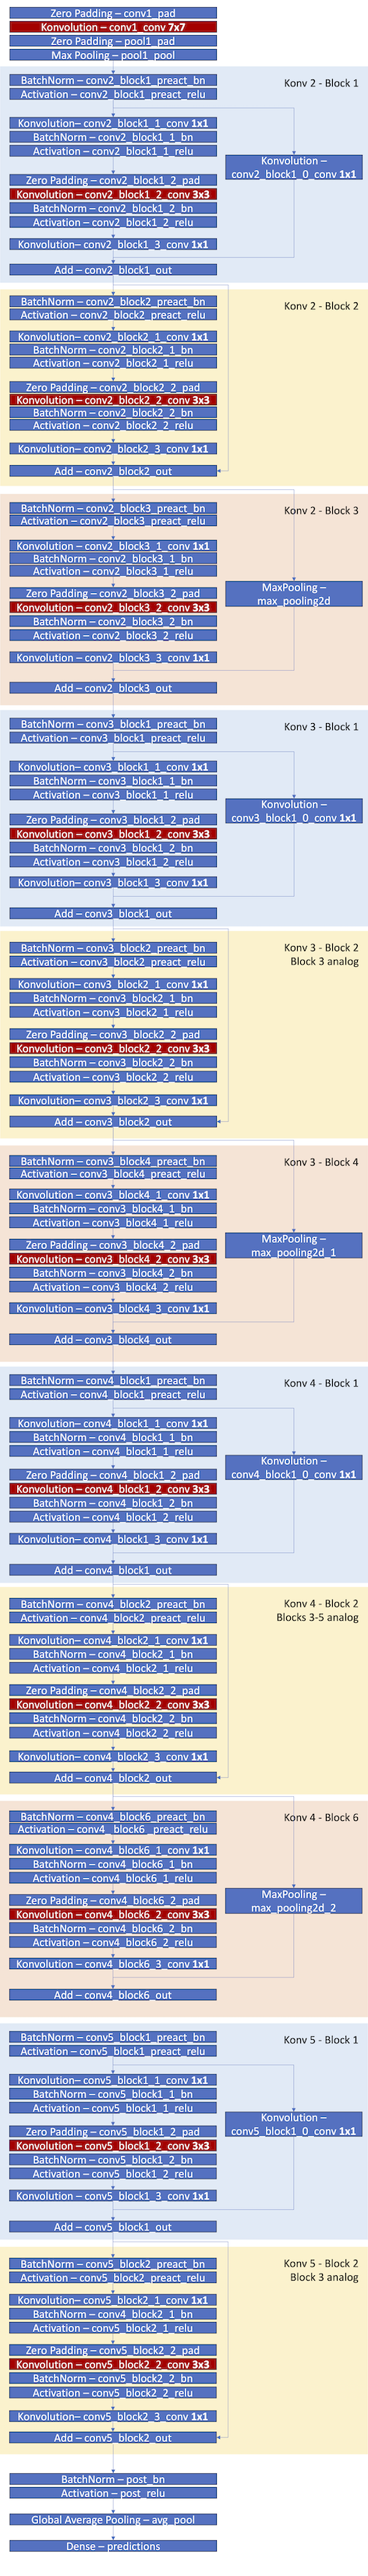

## Eigenschaften einzelner Schichten ansehen

Da wir später auch wissen müssen, welche Indizes die Konvolutionsschichten haben, verwenden wir jetzt noch das Attribut `layers` des Modells, um über alle Schichten zu iterieren und dabei die Variable i als Index mitlaufen zu lassen. Wir ignorieren dabei alle Schichten, die keine Konvolutionsschichten sind und daher keine Konvolutionskerne ('filters') enthalten. Für alle Schichten, die solche Kerne enthalten, lassen wir den Namen sowie die Konfiguration der Schicht ausgeben. Interessant sind hier z.B. die Anzahl der Kerne (zu finden beim Attribut 'filters') sowie die 'kernel_size', also die Größe der Kerne und der Stride.

In [ ]:
i = -1
for layer in resnet_model.layers:
    i=i+1
    # weiter zur nächsten Schicht, falls keine Filterkerne in dieser Schicht
    if 'filters' not in layer.get_config().keys():
        continue
    # wichtigste Eigenschaften der Konvolutionsschicht ausgeben lassen
    print(i, layer.get_config()['name'],"Anzahl Filter:", layer.get_config()['filters'], "Filtergröße", layer.get_config()['kernel_size'], "Stride:",layer.get_config()['strides'] ) #, layer.get_weights())
    # alternativ: alle Eigenschaften ausgeben lassen:
    # print(i, layer.get_config()['name'],layer.get_config())


Der Ausgabe kann man entnehmen, dass sehr viele der Konvolutionsschichten in ResNet Filter der Größe 1x1 verwenden. Dies erscheint auf den ersten Blick ungewöhnlich - schließlich ist ja die Idee, auf Muster in Bildern zu reagieren, indem man per Konvolution eine ganze Region mit mehreren Pixeln erfasst. Dies ist hier aber in wenigen Fällen gegeben - die entsprechenden Schichten waren in der Grafik oben übrigens rot eingefärbt.

In den anderen Fällen dienen die 1x1-Konvolutionsschichten meist dazu, eine sogenannte lineare Projektion durchzuführen. Dies kann man sich so vorstellen: ein Filterkern der Größe 1x1 erfasst genau ein Pixel, dieses aber in allen Kanälen, die diese Schicht als Input bekommt. Die Gewichte, die das Netz für so einen Filterkern gelernt hat, bewirken also nur, dass aus verschiedenen Kanälen stammende Pixel mit unterschiedlichen Werten multipliziert werden - so können also verschiedenen Kanäle mehr oder weniger Gewicht bekommen. In gewisser Weise verfeinert also eine solche 1x1-Schicht die Ergebnisse der vorigen Schichten.

In manchen Fällen dienen 1x1-Konvolutionsschichten auch lediglich dazu, die Anzahl der Kanäle zu verringern oder zu erhöhen. Denn die Kerne gehen jeweils über alle Kanäle und ergeben für jeden Kanal einen Wert. Hat man also 56 Kerne, erhält man hinterher als Output der Schicht auf jeden Fall 56 neue Kanäle, selbst wenn die Schicht als Input sehr viel mehr Kanäle bekam.

Da wir hier interessiert sind, zu visualisieren, wo Muster erkannt werden, sind also eigentlich nur die Konvolutionsschichten wichtig, die tatsächlich größere Kerne verwenden (meist 3x3, und ganz am Anfang auch 7x7).

## Filterkerne einer Schicht visualisieren

Wir visualisieren als erstes die Filterkerne der ersten Konvolutionsschicht mit 7x7 Filtergröße. Dem Output oben können wir entnehmen, dass diese Schicht den Index 2 hat.

Wir speichern die Filterkerne und die dazugehörigen Bias in zwei Variablen (werden aber nur die Filterkerne weiter analysieren):

In [ ]:
filters, biases = resnet_model.layers[2].get_weights()


So kann man überprüfen, ob die Filterkerne die erwartete Form haben:

In [ ]:
filters.shape

Wir haben also wie erwartet in den ersten zwei Dimensionen die Form 7x7. Da wir am Anfang des Netzwerks 3 Kanäle haben (einen für Rot, einen für Grün, einen für Blau), ist die Größe in der dritten Dimension 3. Die Größe der letzten Dimension ist 64 und entspricht der Anzahl der Filterkerne; wir haben also hier ein einziges Objekt, das alle 64 Filterkerne enthält, und jeder dieser Kerne ist wiederum 7x7x3 groß.

Wir plotten jetzt die ersten Filter, und zwar nach Kanälen getrennt. Da verschiedene Filter verschiedene Wertebereiche für die Gewichte haben, und wir für jeden Filter vor allem daran interessiert sind, wo besonders große bzw. besonders kleine Gewichte auftauchen, plotten wir jeden Filter so, dass der kleinste Wert (über alle drei Kanäle) in Weiß dargestellt wird. Dagegen wird der größte Wert im Kanal für Rotwerte in Dunkelrot, der größte Wert im Kanal für Grünwerte in Dunkelgrün, und der größte Wert im Kanal für Blau in Dunkelblau dargestellt.  

In [ ]:
# kleinstes Gewicht in allen Filtern
np.min(filters[:,:,:,:])
# größtes Gewicht in allen Filtern
np.max(filters[:,:,:,:])

In [ ]:
from matplotlib import pyplot

# Anzahl der Filter, die visualisiert werden soll
# n_filters, ix = 64, 1
n_filters, ix = 64, 1 # übersichtlicher, exemplarisch nur die ersten 4 anzusehen

pyplot.figure(figsize=(10,n_filters*1.5))

for i in range(n_filters):
	# Gewichte des Filters holen (letzte Dimension steht für den Filter)
	f = filters[:, :, :, i]
	# die Farbkanäle getrennt plotten
	maps = ['Reds', 'Greens', 'Blues']
	# für eine vernünftige Skalierung
	# kleinstes und größtes Gewicht dieses Filterkerns
	# (über alle drei Kanäle) bestimmen
	cmin = np.min(f[:,:,:])
	cmax = np.max(f[:,:,:])

	for j in range(3):
		# Stelle im Plot festlegen (Zeilen, Spalten, Index)
		ax = pyplot.subplot(n_filters, 3, ix )
		# keine Ticks auf den Achsen anzeigen
		ax.set_xticks([])
		ax.set_yticks([])
		# Filterkanal in der jeweiligen Farbe (RGB) plotten
		pyplot.imshow(f[:, :, j], cmap=maps[j], vmin=cmin, vmax=cmax)
		ix += 1
# Grafik anzeigen
pyplot.show()

# Gewichte der Filterkerne interpretieren

Der erste Filterkern sollte folgendermaßen aussehen:

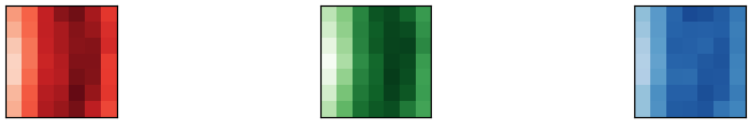

Helle Farben bedeuten niedrige Gewichte (in diesem Fall im negativen Bereich bis ca. -0.25); dunkle Farben bedeuten hohe Gewichte (in diesem Fall im positiven Bereich bis +ca. 0.25). Wichtig ist außerdem zu wissen, dass die RGB-Werte des Bilds nach der ersten Schicht des Netzwerks genau im Bereich von -1 bis +1 liegen.

Der oben gezeigte Filterkern reagiert also vor allem auf Strukturen, bei denen links niedrige Werte für Rot, Grün und Blau und sonst hohe Werte für Rot, Grün und Blau im Input zu finden sind: Denn in diesen Fällen multiplizieren sich im linken Bereich die negativen Gewichte des Filters mit den negativen Farbwerten, so dass sich im Ergebnis wieder relativ hohe positive Werte ergeben. Und  im rechten Bereich multiplizieren sich die relativ hohen positiven Gewichte des Filters an diesen Stellen mit den hohen Werten des Inputs. Dadurch ergeben sich in der Summe besonders hohe Werte, wenn im Bild links negative Werte und rechts positive Werte auftauchen. Da deutlich negative RGB-Werte sehr dunklen Farben entsprechen und deutlich positive RGB-Werte sehr hellen Farben entsprechen, reagiert dieser Filterkern also auf Übergänge von links dunkel nach rechts hell - also auf Kanten, in denen das Bild links dunkel und rechts hell ist. (Zum Ausprobieren von RGB-Werten können Sie die Seite [https://rgbcolorcode.com](https://rgbcolorcode.com/) besuchen.)

Der zweite Filterkern sollte auf Regionen reagieren, die viel Rot, aber wenig Grün und Blau enthalten, denn hier finden sich besonders hohe Gewichte für Rotwerte in der Mitte der Region, während die Gewichte für Grün und Blau durchweg niedriger sind:

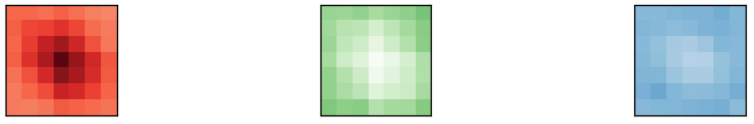

Als weiteres Beispiel betrachten wir noch den sechsten Filterkern. Er scheint auf waagrechte Kanten (oben hell, unten dunkel) zu reagieren. Wenn man ganz genau hinsieht, sind die Gewichte für den blauen Kanal minimal niedriger, so dass der Filterkern noch stärker reagiert, wenn es sich um Übergänge von warmen hellen Tönen zu dunklen Farben handelt, da wärmere Farbtöne besonders hohe Rot- und Grünwerte haben.

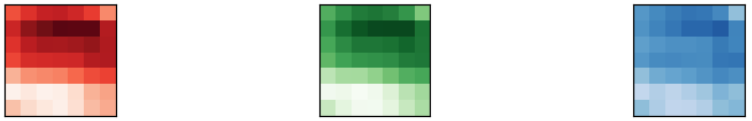

# Beispiele für Feature Maps ansehen

## Bild laden

Wir laden jetzt ein Bild, auf das wir die Filter oben anwenden können, und zu dem wir die sich aus den Filtern ergebenden Feature Maps ansehen können.

In [ ]:
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions

In [ ]:
img_url = 'https://upload.wikimedia.org/wikipedia/commons/9/9b/Afrikanischer_Elefant%2C_Zoo_Miami_1.jpg'
img = load_img(tf.keras.utils.get_file('mein_elefant',img_url), target_size=(224, 224))

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(img)

## Feature Map der ersten Konvolutionsschicht visualisieren

Wir definieren die Schicht, deren Ergebnis wir als Feature Map ansehen wollen. Wir nehmen dafür die erste Konvolutionsschicht. Wir haben oben gesehen, dass sie den Index 2 hat, d.h., wir wollen den Output von Schicht 2 ausgeben lassen.

In [ ]:
layer_fuer_feature_map = tf.keras.Model(inputs=resnet_model.inputs, outputs=resnet_model.layers[2].output)

In [ ]:

# Bild in Array konvertieren
x = img_to_array(img)
# Dimension für den Batch hinzufügen (Batch wird dann nur aus 1 Bild bestehen)
x = np.expand_dims(img, axis=0)
# ResNet-Vorverarbeitung
x = preprocess_input(x)
# Feature Map der oben gewählten Schicht berechnen
feature_maps = layer_fuer_feature_map.predict(x)

Wir untersuchen die Form des Outputs: wir haben ein Batch mit nur einem Bild durch das Netz geschickt und bekommen daher in der ersten Dimension eine 1. Jede Feature Map hat dann 112 x 112 Pixel, und wir haben 64 Feature Maps: eine für jeden Filter in der Schicht.

In [ ]:
feature_maps.shape

Wir plotten jetzt nacheinander die Feature Maps, die sich durch jeden der 64 Filter ergeben. Dunkle Stellen stehen für hohe Werte - in dunklen Regionen im Bild hat der betreffende Filterkern also besonders hohe Werte ergeben, also besonders stark reagiert.

In [ ]:

# Feature Maps plotten
n_filters = 64
row_width = 4

plt.figure(figsize=(10, 10*n_filters // row_width))

ix = 1
for i in range(n_filters // row_width):
    for j in range(row_width):
		# Stelle im Plot festlegen (Zeilen, Spalten, Index)
        ax = plt.subplot(n_filters, row_width, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # Werte der Featuremap für einziges Bild 0 und aktuellen Filterkern holen
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='Greys')
        ix += 1
# show the figure
plt.show()



## Diskussion der Feature Maps

Sehen wir uns die Feature Maps an, die sich durch die drei oben genauer besprochenen Filter ergeben.

Der erste Filter, der vertikale Kanten von dunkel nach hell erkennen sollte, liefert folgenden Output:

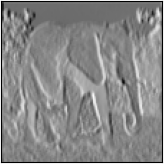

Die dunkelsten Stellen, also die Stellen mit der höchsten Aktivierung, sind hier am linken Stoßzahn (dort findet sich im Bild der Übergang vom dunklen Schatten des Stoßzahns zum sehr hellen Stoßzahn) sowie dort, wo das Gebüsch in den hellen Himmel übergeht. Außerdem an der Außenseite des rechten Schienbeins (dort scheint im Bild neben dem recht dunklen Schienbein im Hintergrund heller Kies zu liegen) und am Übergang vom im Schatten liegenden Bauch zum helleren oberen Bereich des linken Vorderbeins. Im Bild finden sich hier tatsächlich überall vertikale Kanten, bei denen das Bild links dunkel und rechts hell ist.

Für den zweiten Filterkern ergibt sich folgende Feature Map:

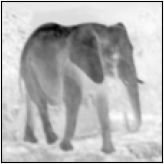

Dieser Filter reagiert, wie oben besprochen, auf Rottöne, und tatsächlich sind die dunkelsten Stellen genau dort, wo im Bild viel Rot ist: auf dem Elefantenrücken sowie auf dem Ohr und an den Füßen. Im Hintergrund finden sich dagegen wenig Rottöne, und daher ist die Feature Map in den Bereichen des Hintergrunds hier sehr hell.

Für das letzte Beispiel, den Filterkern Nummer sechs, hatten wir Reaktion auf horizontale Kanten erwartet, und zwar auf solche, wo das Bild oben hell und unten dunkel ist. Und tatsächlich finden sich die dunkelsten Bereiche an der oberen Kante des Elefantenrückens, unterhalb des Ohrs sowie des Stoßzahns. Auch in den Bäumen finden sich dort, wo oberhalb Himmel ist, Stellen mit hoher Aktivierung. Dagegen reagiert der Filterkern gerade nicht auf Kanten, bei denen das Bild oben dunkel und unten hell ist: an der Unterkante des Bauchs sowie an der Kante zwischen Bäumen und Wiese im rechten Bereich, dort, wo die Struktur gerade umgekehrt ist, sind die Werte besonders niedrig, wie man an den hellen Stellen in diesen Bereichen erkennen kann.

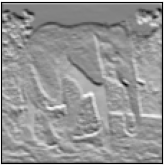

# Entwicklung der Aktivierung über mehrere Schichten verfolgen

Wir haben oben gesehen, dass Regionen mit hoher Aktivierung offensichtlich Strukturen enthalten, auf die der jeweilige Filterkern reagiert. Wir wollen jetzt analysieren, auf welche Strukturen höhere Schichten reagieren.

## Visualisierungsfunktion definieren

Dazu definieren wir eine Funktion, die gezielt die Feature Maps beliebiger Schichten visualisiert. Dabei übergibt man den Index der gewünschten Schicht als Argument. Die Funktion färbt dann für jeden Filterkern der Schicht alle Regionen mit Rottönen ein, in denen die Aktivierung mindestens 80% der maximalen Aktivierung in dieser Schicht erreicht. Die Rottöne werden halbtransparent über eine SW-Version des Bilds gelegt, so dass erkennbar ist, um welche Bildregionen es sich handelt.

In [ ]:
import uuid
from PIL import Image

# Funktion zur Visualisierung
# Argumente: Index der Schicht sowie URL eines Bildes, das klassifiziert werden soll
# und Monitorauflösung, um zu lange Plots zu vermeiden
def show_map(layer_id, bild_url, my_dpi):

    # erzeuge einen zufälligen Dateinamen
    temp_filename = str(uuid.uuid4())
    # speichere das Bild von der angegebenen URL in einer Datei dieses Namens
    img = load_img(tf.keras.utils.get_file(temp_filename,bild_url), target_size=(224, 224))
    # eine Version des Bilds in Schwarz-Weiß erzeugen
    grayscale_img = img.convert("L")
    # farbiges Bild zeigen
    plt.figure()
    plt.imshow(img)

    # gewünschte Schicht finden
    layer_fuer_feature_map = tf.keras.Model(inputs=resnet_model.inputs, outputs=resnet_model.layers[layer_id].output)

    # Farbbild einmal komplett durch das Netzwerk schicken
    x = img_to_array(img)
    x = np.expand_dims(img, axis=0)
    x = preprocess_input(x)
    # Erkennungsergebnis ausgeben lassen
    print('Predicted:', tf.keras.applications.resnet_v2.decode_predictions(resnet_model.predict(x), top=3)[0])

    # Feature Map der oben gewählten Schicht berechnen
    feature_maps = layer_fuer_feature_map.predict(x)

    # Feature Maps plotten
    # benötigte Filteranzahl ermitteln
    n_filters = resnet_model.layers[layer_id].get_config()['filters']
    row_width = 4

    # falls Plot länger als 2^16=65536 Pixel wird, Auflösung reduzieren
    while my_dpi * 10*n_filters//row_width > 65536:
        my_dpi = my_dpi*0.8
        print('Reduziere Auflösung auf',my_dpi)

    #plt.figure(figsize=(10, min(600, 10*n_filters // row_width))) # falls man bei Schichten mit sehr vielen Filtern nicht alle anzeigen möchte
    plt.figure(figsize=(10, 10*n_filters // row_width ),dpi=my_dpi)

    # Maximale Aktivierung in dieser Schicht finden
    # erster Index 0, weil nur ein Bild als Input
    # Maximum dann aber über alle Filterkerne
    overall_max = np.max(feature_maps[0,:,:,:])
    overall_min = np.min(feature_maps[0,:,:,:])
    print("Max", overall_max)
    print("Min", overall_min)
    # Schwellwert 80% des Maximums
    upper_threshold = overall_min + 0.8 * ( overall_max - overall_min)

    # Schleife über alle Filter der Schicht
    ix = 1
    for i in range(n_filters // row_width):
        for j in range(row_width):
		    # Stelle im Plot festlegen (Zeilen, Spalten, Index)
            ax = pyplot.subplot(n_filters, row_width, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # SW-Version des Bilds als Hintergrund plotten
            plt.imshow(grayscale_img,extent=(0,10,0,10),cmap="gray")
            # Werte der Featuremap für einziges Bild 0 und aktuellen Filterkern holen
            current_feature_map = feature_maps[0,:,:,ix-1]
            # nur die Aktivierungen behalten, die über dem Schwellwert liegen, Rest auf 0
            high_map_activation = tf.where(current_feature_map > upper_threshold, current_feature_map, 0.0)
            # hohe Aktivierung durch Rottöne visualisieren
            # dabei Transparenz 0.5, so dass SW-Bild im Hintergrund sichtbar
            plt.imshow(high_map_activation, cmap='Reds',alpha=0.5,extent=(0,10,0,10))
            ix += 1
            
    # show the figure
    plt.show()



## Maximale Aktivierung visualisieren

Wir wenden die Funktion jetzt auf beliebige Bilder an. Unten finden Sie verschiedene auskommentierte Funktionsaufrufe mit Bilder aus verschiedenen Quellen und Feature Maps in unterschiedlichen Schichten, die sie gerne ausprobieren können. Sie sollten hier auch eigene Bilder suchen und verarbeiten lassen.

Das letzte Beispiel wird unten besprochen.

Hier ist noch eine Liste der Indizes der Konvolutionsschichten, die Filterkerne haben, die größer als 1x1 sein, die also wirklich auf Strukturen über mehrere Pixel reagieren:

2 11 23 34 46 58 69 80 92 104 115 126 137 148 160 172 183

Die Visualisierung der Feature Maps dieser Schichten ist also sinnvoll.

Es ist auch möglich, die Funktion auf Konvolutionsschichten mit 1x1 Kernen anzuwenden, probieren Sie es gerne aus. Die Indizes finden Sie oben im Abschnitt "Eigenschaften einzelner Schichten ansehen".

Für alle anderen Indizes wird die oben definierte Funktion einen Fehler liefern, da dort die in der Funktion verwendeten Eigenschaften (z.B. die Anzahl der Filterkerne) nicht definiert sind.

In [ ]:
# vermutete Monitor-Auflösung
# kann erhöht werden, falls höhere Auflösung möglich
# wird von show_map reduziert, falls Plot sonst zu lang
my_dpi = 96

#show_map(2,'https://upload.wikimedia.org/wikipedia/commons/e/e1/Dafna_Ben_nun_with_Emperor_Penguins.jpg', my_dpi)
#show_map(11,'https://upload.wikimedia.org/wikipedia/commons/9/9b/Afrikanischer_Elefant%2C_Zoo_Miami_1.jpg', my_dpi)
#show_map(2,'https://upload.wikimedia.org/wikipedia/commons/0/0f/Cameleons.jpg', my_dpi)
#show_map(11,'https://upload.wikimedia.org/wikipedia/commons/0/0f/Cameleons.jpg', my_dpi)
#show_map(80,'https://upload.wikimedia.org/wikipedia/commons/f/f9/STOP_sign.jpg', my_dpi)
#show_map(11,'https://upload.wikimedia.org/wikipedia/commons/3/3a/A_red_squirrel%2C_the_redness_of_its_tail_particularly_vibrant_against_a_background_of_green_plants_%288f0fb4d4-9388-4c00-b799-551f555d752f%29.jpg', my_dpi)
#show_map(23,'https://upload.wikimedia.org/wikipedia/commons/3/3a/A_red_squirrel%2C_the_redness_of_its_tail_particularly_vibrant_against_a_background_of_green_plants_%288f0fb4d4-9388-4c00-b799-551f555d752f%29.jpg', my_dpi)
#show_map(80,'https://upload.wikimedia.org/wikipedia/commons/3/3a/A_red_squirrel%2C_the_redness_of_its_tail_particularly_vibrant_against_a_background_of_green_plants_%288f0fb4d4-9388-4c00-b799-551f555d752f%29.jpg', my_dpi)
#show_map(2, 'https://i.pinimg.com/originals/2d/80/80/2d808012b106c9a5465de4848dbaf0db.jpg', my_dpi)
#show_map(172, 'https://i.pinimg.com/originals/2d/80/80/2d808012b106c9a5465de4848dbaf0db.jpg', my_dpi)
show_map(183, 'https://i.pinimg.com/originals/2d/80/80/2d808012b106c9a5465de4848dbaf0db.jpg', my_dpi)


## Diskussion eines Beispiels

Der letzte Funktionsaufruf oben visualisierte den Output der letzten Konvolutionsschicht für ein Bild, auf dem ein graues Eichhörnchen und ein roter Vogel (ein roter Kardinal) sichtbar sind.

Es ist natürlich eigentlich klar, dass ResNet hier Schwierigkeiten haben wird, denn im Bild sind zwei Tiere, während ResNet für jedes Bild immer nur eine Klasse bestimmt. Interessant sind aber die Feature Maps, die sich hier ergeben.

Zunächst mal kann man ganz oben, nach der Ausgabe des Bilds selbst, sehen, dass
die Klasse mit der höchsten Wahrscheinlichkeit tatsächlich ein Eichhörnchen ist: die erste Klasse ist "fox_squirrel", auf Deutsch: Fuchshörnchen. Das ist eine in den USA verbreitete Eichhörnchenart, mit deren Bildern ResNet trainiert wurde. Die Tiere sehen eher gräulich-rot aus, sie sind nicht so rot wie europäische Eichhörnchen. ResNet erkennt das Tier hier mit einer Wahrscheinlichkeit von 86.5%.

Interessant ist, dass als zweite mögliche Klasse (mit 6.79%) ein "goldfinch" erkannt wird. Das ist auf Deutsch der Stieglitz. Er ist sehr bunt und nur am Schnabel rot. Im Bild dagegen handelt es sich um einen sogenannten Roten Kardinal, den ResNet aber nicht erkennen kann, weil es darauf nicht trainiert wurde. Immerhin ist der Stieglitz ebenfalls ein Vogel, wenn auch die Farbe anders ist.

Wir betrachten den Verlauf der Aktivierung von Schicht zu Schicht. In der ersten Konvolutionsschicht mit Index 2 reagiert ResNet, wie zu erwarten, im Bereich des Vogels auf das Rot, ansonsten noch an einigen Stellen auf Kanten an den Füßen des Eichhörnchens. In der Schicht darüber, mit Index 11, sind die Aktivierungen diffuser und reagieren auf Strukturen im Fell und am Boden. In der vierten Schicht (Index 34) werden dann Bereiche aktiv, in denen sich typische relevante Strukturen finden: Schnabel, Pfoten, Brust, und so weiter, allerdings noch sehr lokal. In höheren Schichten werden die Aktivierungen wieder diffuser und finden sich auch im Hintergrund. In den höchsten Schichten kann man beobachten, dass die Aktivierungen immer konsistenter relevante Bereiche im Bild betreffen. 

Wenn man sich die Aktivierungen in der letzten 3x3 Konvolutionsschicht mit Index 183 ansieht, kann man feststellen, dass die höchsten Aktivierungen hier sowohl an der Stelle auftauchen, wo das Eichhörnchen sitzt, als auch an der Stelle, wo der rote Kardinal im Bild ist. Man kann daraus schließen, dass ResNet hier eben an mehreren Stellen im Bild Strukturen erkannt hat, die zu Objekten passen, auf die es trainiert wurde. Man kann also auch noch in den obersten Schichten eine räumliche Zuordnung von Aktivierungen in Feature Maps zu interessanten Strukturen an der entsprechenden Stelle im Bild feststellen.

Interessant sind hier auch noch die Feature Maps der allerletzten  Konvolutionsschicht (dafür den Funktionsaufruf so abändern, dass statt Schicht 183 Schicht 185 verwendet wird). Bei dieser Schicht handelt es sich "nur" um eine 1x1 Konvolutionsschicht, die insofern nicht mehr auf Muster im Bild reagiert, weil sie nur noch Regionen von 1x1 Pixel betrachtet. Ihr Effekt ist es, für jedes Pixel in der letzten Feature Map nochmal die wichtigsten Kanäle zu verstärken, und dabei von 512 Kanälen auf 2048 Kanäle abzubilden (dies wurde oben im Abschnitt "Eigenschaften einzelner Schichten ansehen" besprochen). Achtung, man bekommt daher auch sehr langen Output mit 2048 Feature Maps. Scrollt man durch sie durch, findet man aber im Vergleich zur vorletzten Schicht 183 nur noch in einer Feature Map Aktivierungen, die den Schwellwert überschreiten, und zwar dort, wo das Eichhörnchen sitzt.

In der Schicht darunter, beim Output für Index 183 also, sind in manchen Maps noch bei beiden Tieren hohe Aktivierungen zu erkennen.



Abschließend lässt sich also sagen, dass man mit etwas Mühe oft noch nachverfolgen kann, worauf neuronale Netzwerke reagieren. Allerdings wird dies von Schicht zu Schicht schwieriger.

Für Bilderkennung mit Konvolutionsnetzwerken, so wie hier illustriert, ist dies durch Abgleich der Feature Maps mit dem Originalbild einigermaßen möglich. In anderen Fällen kann die Interpretation durchaus noch schwieriger werden.